# Rain Reports
Initial Development

In [170]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import contextily as cx

from raindownloader.inpeparser import INPE, INPEParsers, INPETypes
from raindownloader.inpedownloader import Downloader
from raindownloader.utils import FileType, DateProcessor
from rainreporter.reporter import RainReporter

import rasterio as rio
import xarray as xr
from raindownloader.utils import GISUtil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
reporter = RainReporter(server=INPE.FTPurl, download_folder='../tmp', parsers=INPEParsers.parsers)

In [172]:
reporter.downloader.download_range(
    start_date='20230101', 
    end_date='20230102',
    # file_type=FileType.GEOTIFF,
    datatype=INPETypes.DAILY_RAIN,
    local_folder='../tmp'
)

[PosixPath('../tmp/MERGE_CPTEC_20230101.grib2'),
 PosixPath('../tmp/MERGE_CPTEC_20230102.grib2')]

In [173]:
rain = reporter.get_cube(    
    start_date='20230101', 
    end_date='20230102', 
    datatype=INPETypes.DAILY_RAIN
).to_array()

In [174]:
rain.rio.crs

CRS.from_epsg(4326)

In [175]:
rain = xr.open_dataset('../tmp/MERGE_CPTEC_20230101.grib2')
rain

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-03-29T10:34 GRIB to CDM+CF via cfgrib-0.9.1...

In [176]:
rain.time.data

numpy.datetime64('2023-01-01T12:00:00.000000000')

In [177]:
rain = rain.rio.write_crs('epsg:4326')

In [178]:
rainarray = rain['prec']

In [179]:
rainarray.expand_dims(dim='band')

<xarray.DataArray 'prec' (band: 1, latitude: 924, longitude: 1001)>
array([[[2.25 , 1.75 , 1.75 , ..., 0.   , 0.   , 0.   ],
        [0.75 , 0.625, 0.75 , ..., 0.   , 0.   , 0.   ],
        [0.5  , 0.375, 0.25 , ..., 0.   , 0.   , 0.   ],
        ...,
        [3.25 , 3.375, 3.625, ..., 2.375, 1.75 , 1.375],
        [2.25 , 2.125, 3.125, ..., 1.75 , 1.5  , 1.25 ],
        [2.875, 2.25 , 1.75 , ..., 1.75 , 1.375, 1.375]]], dtype=float32)
Coordinates:
    time         datetime64[ns] 2023-01-01T12:00:00
    step         timedelta64[ns] ...
    surface      float64 ...
  * latitude     (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude    (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time   datetime64[ns] ...
    spatial_ref  int64 0
Dimensions without coordinates: band
Attributes: (12/29)
    GRIB_paramId:                             260138
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      924924
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Precipitation
    GRIB_shortName:                           prec
    GRIB_units:                               kg m**-2
    long_name:                                Precipitation
    units:                                    kg m**-2
    standard_name:                            unknown

In [180]:
rainarray

<xarray.DataArray 'prec' (latitude: 924, longitude: 1001)>
array([[2.25 , 1.75 , 1.75 , ..., 0.   , 0.   , 0.   ],
       [0.75 , 0.625, 0.75 , ..., 0.   , 0.   , 0.   ],
       [0.5  , 0.375, 0.25 , ..., 0.   , 0.   , 0.   ],
       ...,
       [3.25 , 3.375, 3.625, ..., 2.375, 1.75 , 1.375],
       [2.25 , 2.125, 3.125, ..., 1.75 , 1.5  , 1.25 ],
       [2.875, 2.25 , 1.75 , ..., 1.75 , 1.375, 1.375]], dtype=float32)
Coordinates:
    time         datetime64[ns] 2023-01-01T12:00:00
    step         timedelta64[ns] ...
    surface      float64 ...
  * latitude     (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude    (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time   datetime64[ns] ...
    spatial_ref  int64 0
Attributes: (12/29)
    GRIB_paramId:                             260138
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      924924
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Precipitation
    GRIB_shortName:                           prec
    GRIB_units:                               kg m**-2
    long_name:                                Precipitation
    units:                                    kg m**-2
    standard_name:                            unknown

In [181]:
import rioxarray as xrio

In [182]:
rain = xrio.open_rasterio('../tmp/MERGE_CPTEC_20230101.grib2')

In [183]:
rain.attrs['GRIB_IDS']

'SUBCENTER=0 MASTER_TABLE=1 LOCAL_TABLE=0 SIGNF_REF_TIME=0(Analysis) REF_TIME=2023-01-01T12:00:00Z PROD_STATUS=0(Operational) TYPE=0(Analysis)'

## Opening Basins of Interest

In [184]:
shapes_mac = Path('/Users/cordmaur/Library/CloudStorage/OneDrive-AgênciaNacionaldeÁguas/Trabalho/SOE/COVEC/Bases/bacias de interesse SOE')
shapes_container = Path('/workspaces/bases/bacias de interesse SOE')

shapes = shapes_mac if shapes_mac.exists() else shapes_container
assert shapes.exists()

In [185]:
basins = {file.stem.split('_')[-1]: file for file in shapes.iterdir() if file.suffix == '.shp'}

In [186]:
basins

{'Doce': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Doce.shp'),
 'wgs84': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Doce_wgs84.shp'),
 'Itapecuru': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Itapecuru.shp'),
 'Jequitinhonha': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Jequitinhonha.shp'),
 'Madeira': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Madeira.shp'),
 'PortoVelho': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Madeira_em_PortoVelho.shp'),
 'Negro': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Negro.shp'),
 'Paraguai': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Paraguai.shp'),
 'ParaibaDoSul': PosixPath('/workspaces/bases/bacias de interesse SOE/bacias50k_ParaibaDoSul.shp'),
 'Parana': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Parana.shp'),
 'Pardo': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Pardo.shp'),
 'Parnaiba': PosixPa

## Make the report

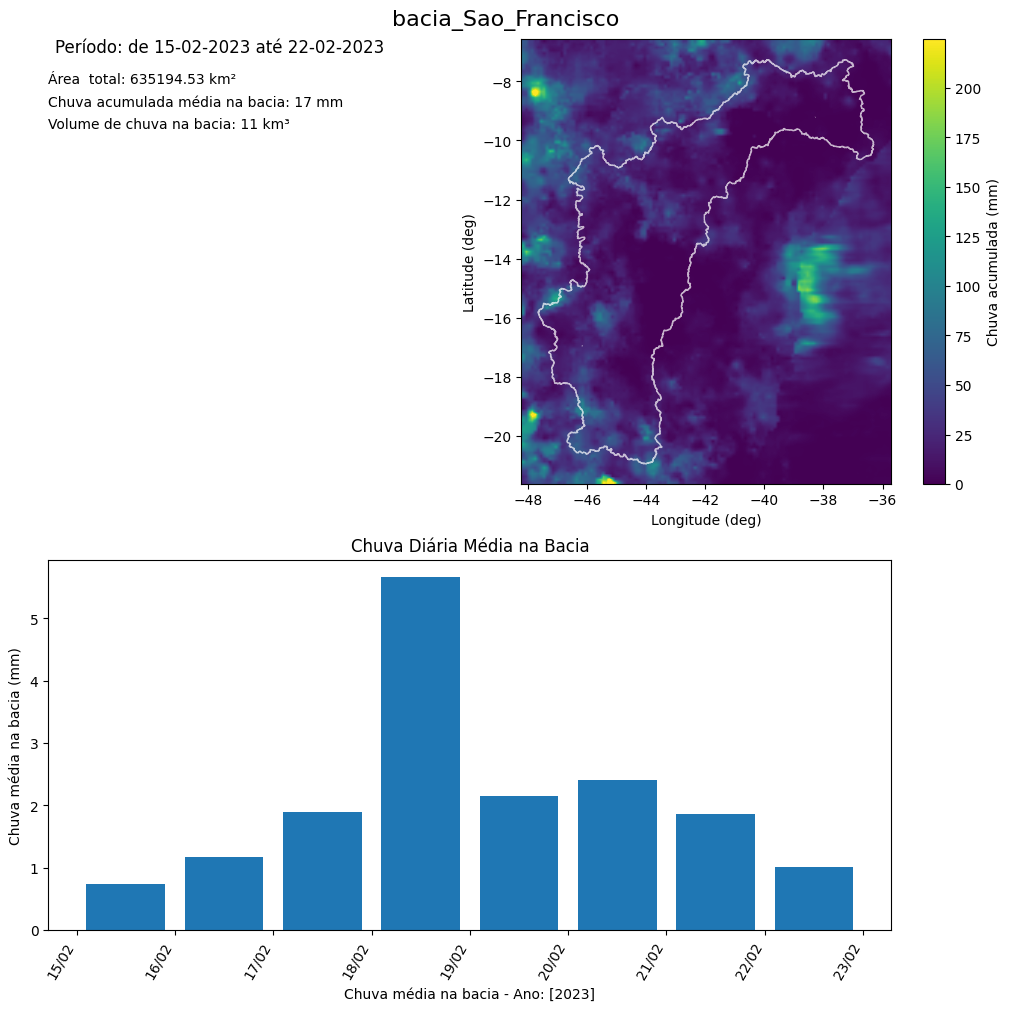

In [187]:
ax, rain, shp, cube = reporter.rain_report('20230215', '20230222', basins['Francisco'])

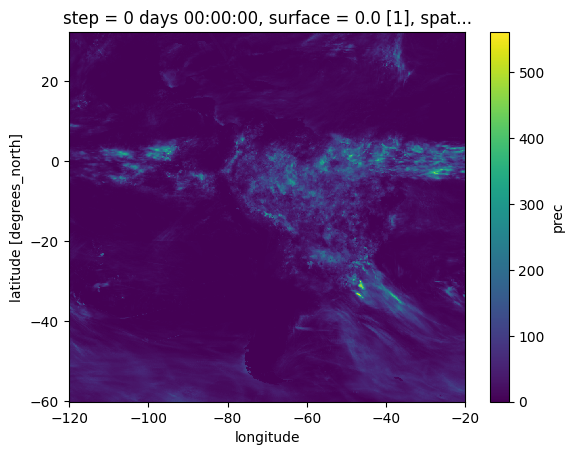

In [188]:
rain.plot()

In [189]:
RainReporter.rain_in_geoms(cube, geometries=shp.geometry)

{'volume (kmˆ3)': 1.3423998207506926,
 'area (kmˆ2)': 635194.5325772106,
 'height (mm)': 2.113368034362793}

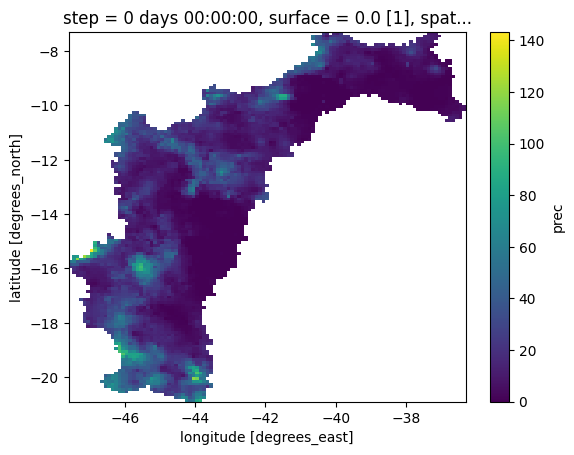

In [190]:
rain.rio.clip(shp.geometry).plot()

In [191]:
reporter.animate_rain('20230222', '20230307', basins['ANA'], '../animacao.gif')

TypeError: RainReporter.get_cube() missing 1 required positional argument: 'datatype'

In [ ]:
%%timeit

import io

def animate_cube(cube: xr.DataArray, local_folder: Path):

    files = []
    local_folder = Path(local_folder)

    fig = plt.figure()

    for date in cube.date.data:
        ax = fig.add_subplot()
        RainReporter.plot_raster_shape(cube.sel(date=date), shape=shp, plt_ax=ax)
        date_str = DateProcessor.pretty_date(pd.to_datetime(date).to_pydatetime())
        print(date_str)
        fname = local_folder/f'ani-{date_str}.png'
        fig.suptitle(f'Dia {date_str}', x=0.4)
        fig.savefig(fname)
        files.append(fname)

        fig.clear()

    return files

def animate_cube_in_memory(cube: xr.DataArray):
    

    files = []

    fig = plt.figure()

    for date in cube.date.data:
        ax = fig.add_subplot()
        RainReporter.plot_raster_shape(cube.sel(date=date), shape=shp, plt_ax=ax)
        date_str = DateProcessor.pretty_date(pd.to_datetime(date).to_pydatetime())
        print(date_str)
        fig.suptitle(f'Dia {date_str}', x=0.4)

        # Create a temporary file
        file_like = io.BytesIO()

        fig.savefig(file_like)


        files.append(file_like)

        fig.clear()

    return files

files = animate_cube_in_memory(cube)
# 5.49 s ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# files = animate_cube(cube, '../tmp/')
# 5.57 s ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

from PIL import Image

images = []
for file in files:
    img = Image.open(file)
    images.append(img)

images[0].save('../animation.gif', save_all=True, append_images=images[1:], duration=200, loop=True)

22-02-2023
23-02-2023
24-02-2023
25-02-2023
26-02-2023
27-02-2023
28-02-2023
01-03-2023
02-03-2023
03-03-2023
04-03-2023
05-03-2023
06-03-2023
07-03-2023
22-02-2023
23-02-2023
24-02-2023
25-02-2023
26-02-2023
27-02-2023
28-02-2023
01-03-2023
02-03-2023
03-03-2023
04-03-2023
05-03-2023
06-03-2023
07-03-2023
22-02-2023
23-02-2023
24-02-2023
25-02-2023
26-02-2023
27-02-2023
28-02-2023
01-03-2023
02-03-2023
03-03-2023
04-03-2023
05-03-2023
06-03-2023
07-03-2023
22-02-2023
23-02-2023
24-02-2023
25-02-2023
26-02-2023
27-02-2023
28-02-2023
01-03-2023
02-03-2023
03-03-2023
04-03-2023
05-03-2023
06-03-2023
07-03-2023
22-02-2023
23-02-2023
24-02-2023
25-02-2023
26-02-2023
27-02-2023
28-02-2023
01-03-2023
02-03-2023
03-03-2023
04-03-2023
05-03-2023
06-03-2023
07-03-2023
22-02-2023
23-02-2023
24-02-2023
25-02-2023
26-02-2023
27-02-2023
28-02-2023
01-03-2023
02-03-2023
03-03-2023
04-03-2023
05-03-2023
06-03-2023
07-03-2023
22-02-2023
23-02-2023
24-02-2023
25-02-2023
26-02-2023
27-02-2023
28-02-2023

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
files

[PosixPath('../tmp/ani-22-02-2023.png'),
 PosixPath('../tmp/ani-23-02-2023.png'),
 PosixPath('../tmp/ani-24-02-2023.png'),
 PosixPath('../tmp/ani-25-02-2023.png'),
 PosixPath('../tmp/ani-26-02-2023.png'),
 PosixPath('../tmp/ani-27-02-2023.png'),
 PosixPath('../tmp/ani-28-02-2023.png'),
 PosixPath('../tmp/ani-01-03-2023.png'),
 PosixPath('../tmp/ani-02-03-2023.png'),
 PosixPath('../tmp/ani-03-03-2023.png'),
 PosixPath('../tmp/ani-04-03-2023.png'),
 PosixPath('../tmp/ani-05-03-2023.png'),
 PosixPath('../tmp/ani-06-03-2023.png'),
 PosixPath('../tmp/ani-07-03-2023.png')]

In [ ]:
from PIL import Image

images = []
for file in files:
    img = Image.open(file)
    images.append(img)

images[0].save('../animation.gif', save_all=True, append_images=images[1:], duration=200, loop=True)

In [ ]:
365*20

7300

In [ ]:
import xarray as xr

In [ ]:
acum_2022 = xr.open_dataset('/Users/cordmaur/Downloads/MERGE_CPTEC_acum_2022.nc')

ValueError: found the following matches with the input file in xarray's IO backends: ['netcdf4', 'h5netcdf']. But their dependencies may not be installed, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

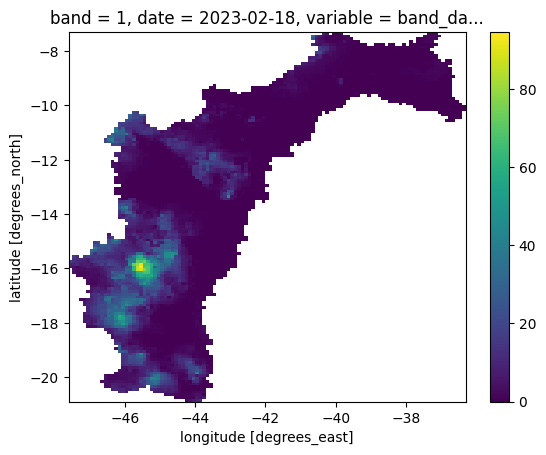

In [ ]:
sf.sel(date='2023-02-18').plot()

In [ ]:
cube.mean(dim=['x', 'y'])

<xarray.DataArray (variable: 1, date: 8)>
array([[3.04344985, 3.21755139, 3.58143223, 3.13941443, 3.23323619,
        2.8574464 , 3.1429212 , 2.28810577]])
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2023-02-15 2023-02-16 ... 2023-02-22
  * variable     (variable) object 'band_data'

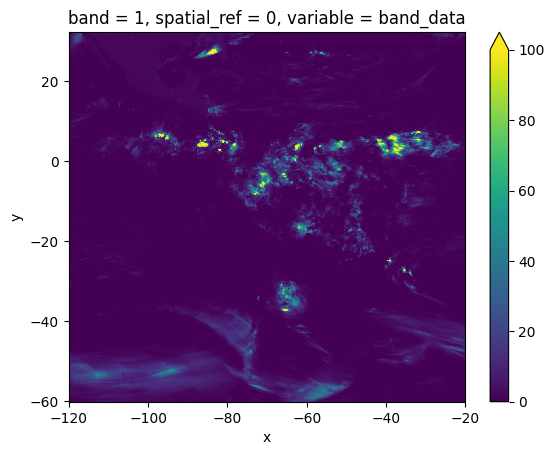

In [ ]:
rain.plot(vmin=0, vmax=100)

In [ ]:
cb.vmax

396.75

In [ ]:
solimoes_df = gpd.read_file(basins['Solimoes'])

In [ ]:
solimoes = rain.rio.clip(solimoes_df.geometry)

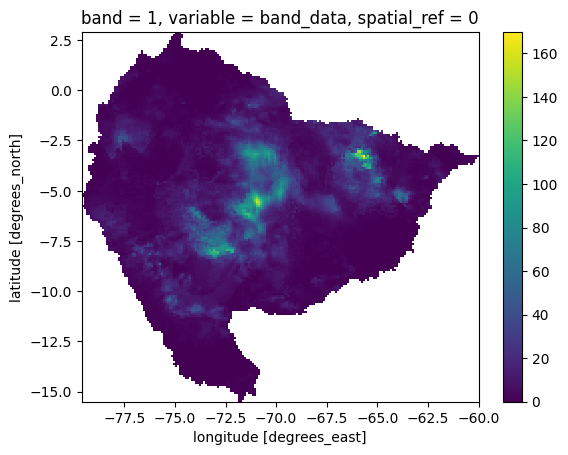

In [ ]:
solimoes.plot()

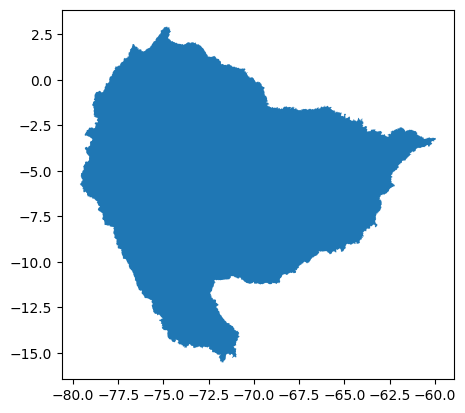

In [ ]:
plt_ax = shp.plot()

In [ ]:
xmin, xmax, ymin, ymax = plt_ax.axis()

In [ ]:
solimoes2 = rain.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

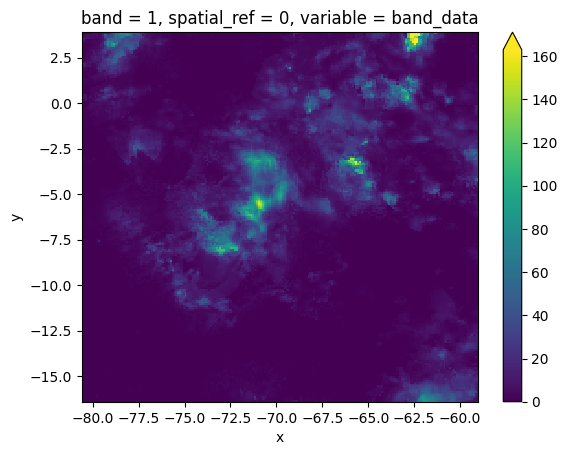

In [ ]:
solimoes2.plot(vmax=163)

#### Testing contextily with full extent

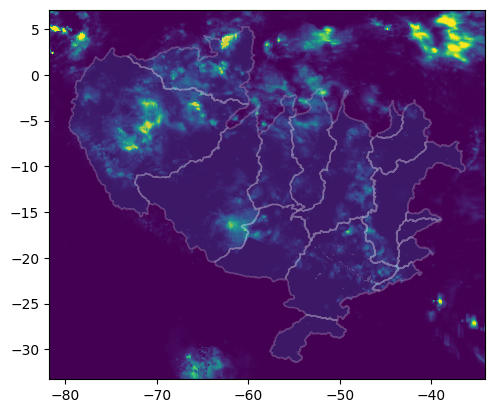

In [ ]:
# create a memory file and use it to create a memory dataset
profile = GISUtil.profile_from_xarray(rain)
plt_ax = shp.plot(edgecolor='white', alpha=0.2)

with rio.MemoryFile() as memfile:
    with memfile.open(**profile) as memdset:

        # write the data to the newly created dataset
        memdset.write(rain)

    # with the dataset in memory, add the basemap
    cx.add_basemap(plt_ax, source=memfile, reset_extent=True, vmin=0, vmax=100)

    # now, let's create a colorbar for this 

In [ ]:
xmin, xmax, ymin, ymax = ax[0].axis()
xmin, xmax, ymin, ymax

(-81.782475845, -34.13700885499984, -33.27862147999995, 7.116077479999998)

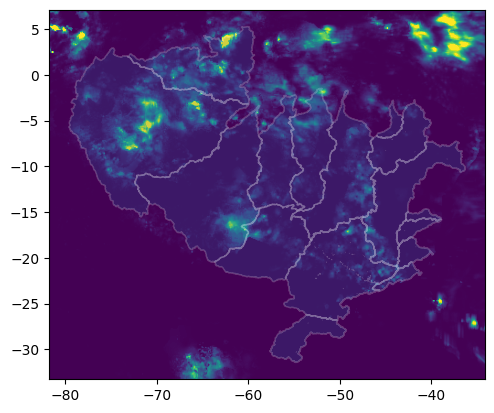

In [ ]:
rain_basins = rain.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

# create a memory file and use it to create a memory dataset
profile = GISUtil.profile_from_xarray(rain_basins)
rain_basins = rain.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))
plt_ax = shp.plot(edgecolor='white', alpha=0.2)

with rio.MemoryFile() as memfile:
    with memfile.open(**profile) as memdset:

        # write the data to the newly created dataset
        memdset.write(rain_basins)

    # with the dataset in memory, add the basemap
    cx.add_basemap(ax=plt_ax, source=memfile, reset_extent=True, vmin=0, vmax=100)

    # now, let's create a colorbar for this 


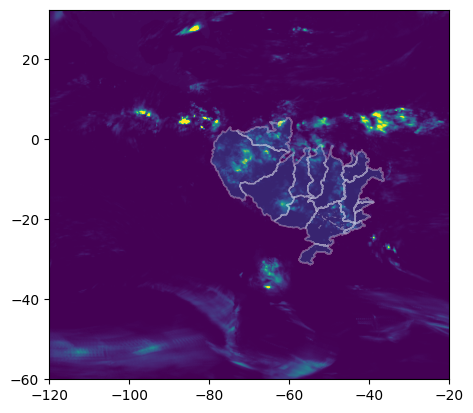

In [ ]:
ax = shp.plot(alpha=0.3, edgecolor='white')
cx.add_basemap(ax=ax, source='../tmp/MERGE_CPTEC_20230101.tif', reset_extent=False, vmin=0, vmax=100)

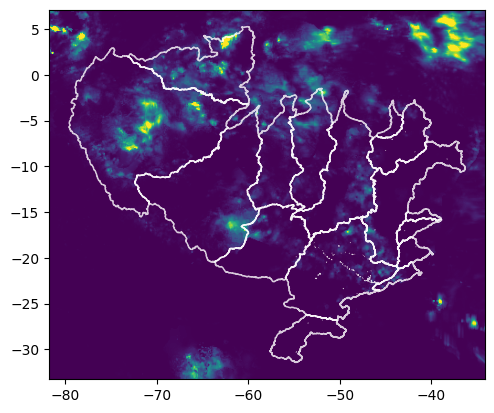

In [ ]:
ax = shp.plot(alpha=0.8, edgecolor='white', facecolor='none')
cx.add_basemap(ax=ax, source='../tmp/MERGE_CPTEC_20230101.tif', reset_extent=True, vmin=0, vmax=100)

## Insert a colorbar

In [ ]:
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

In [ ]:

def create_colorbar(raster: xr.DataArray, plt_ax: plt.Axes, label: str, labelsize: int=12):
    vmin = float(raster.min())
    vmax = float(raster.max())

    # Create a colorbar object with the desired range of values
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=plt_ax)

    # Customize the colorbar
    cb.set_label('Chuva acumulada (mm)')
    cb.ax.tick_params(labelsize=12)

    # Show the plot
    plt.show()

file ../tmp/MERGE_CPTEC_20230101.grib2 already exists.
16 featuers found in shapefile, selecting all of them.


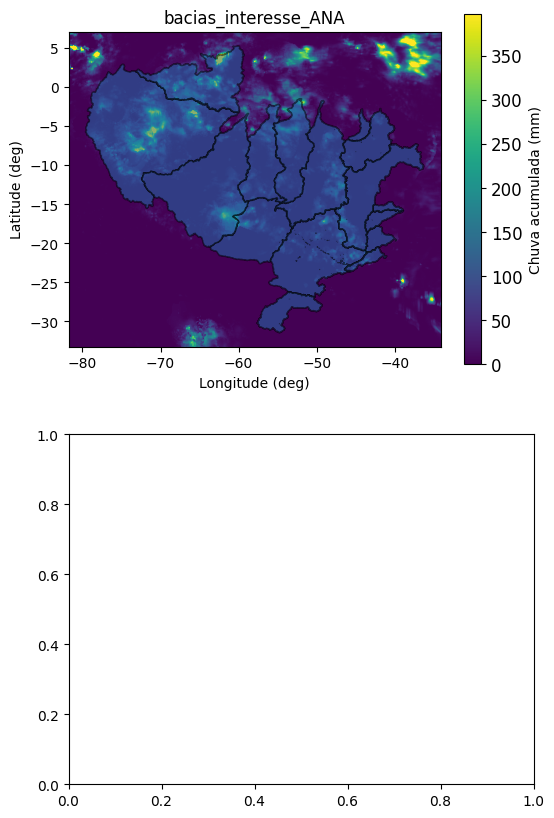

In [ ]:


ax, rain, shp = reporter.rain_report('20230101', '20230101', basins['ANA'])

# Define the range of values that the colormap will map to colors
vmin = float(rain.min())
vmax = float(rain.max())

# Create a colorbar object with the desired range of values
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax[0])

# Customize the colorbar
cb.set_label('Chuva acumulada (mm)')
cb.ax.tick_params(labelsize=12)

# Show the plot
plt.show()

In [ ]:
rain_basins.max()

<xarray.DataArray ()>
array(396.75)
Coordinates:
    band         int64 1
    spatial_ref  int64 ...

<Axes: >

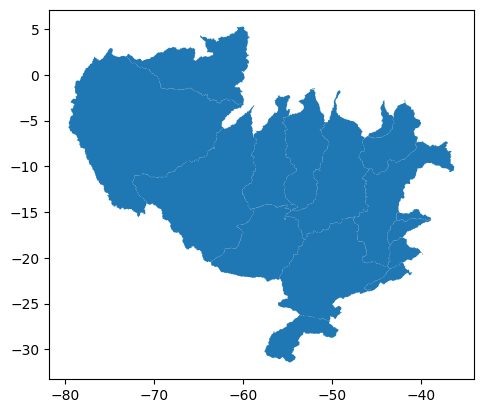

In [ ]:
shp.plot(facecolor=None)

In [ ]:
shp.geometry

0     POLYGON ((-44.25224 -6.70522, -44.25211 -6.705...
1     POLYGON ((-42.11708 -17.76730, -42.11709 -17.7...
2     POLYGON ((-43.49448 -18.60516, -43.49541 -18.6...
3     POLYGON ((-56.84775 -14.14656, -56.84693 -14.1...
4     POLYGON ((-51.39568 -26.72575, -51.39666 -26.7...
5     POLYGON ((-41.66140 -16.01446, -41.66147 -16.0...
6     POLYGON ((-44.92269 -10.92541, -44.92360 -10.9...
7     POLYGON ((-39.89622 -7.26287, -39.89550 -7.263...
8     POLYGON ((-71.10284 -15.20953, -71.10342 -15.2...
9     POLYGON ((-54.52453 -14.88452, -54.52560 -14.8...
10    POLYGON ((-54.77757 -31.42922, -54.77824 -31.4...
11    POLYGON ((-60.51452 -3.22621, -60.51565 -3.226...
12    POLYGON ((-62.78987 -19.90574, -62.79051 -19.9...
13    POLYGON ((-42.19563 -20.43441, -42.19415 -20.4...
14    POLYGON ((-53.05885 -18.04708, -53.05923 -18.0...
15    POLYGON ((-53.91953 -14.83702, -53.91962 -14.8...
Name: geometry, dtype: geometry

Text(0, 0.85, 'Volume de chuva na bacia: 0 km³')

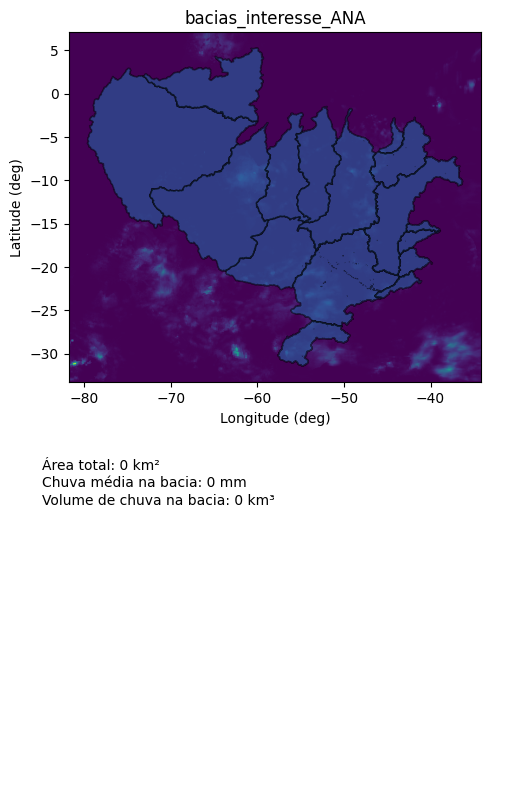

In [ ]:
ax[0].figure

In [ ]:
a = ax[0]

In [ ]:
leg = a.get_legend()

In [ ]:
leg.set_bbox_to_anchor((1, 0.5))

In [ ]:
leg.set_title("Category") 

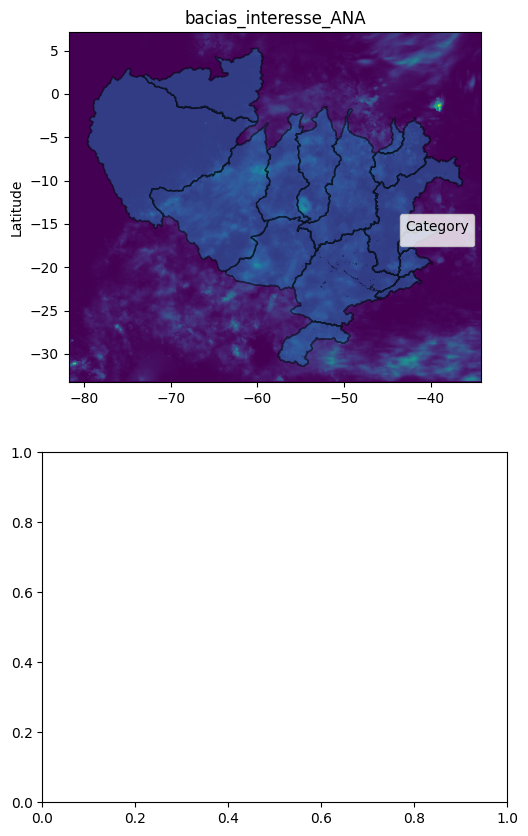

In [ ]:
a.figure

In [ ]:
a.set_ylabel('Latitude')
a.set_xlabel('Longitude')

Text(0.5, 424.44444444444446, 'Longitude')

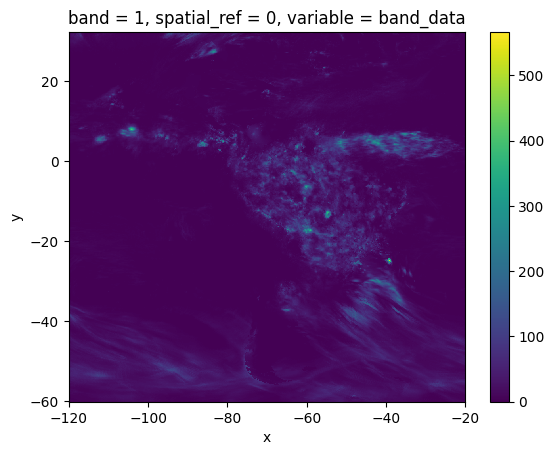

In [ ]:
rain.plot()

In [ ]:
float(rain.min())

0.0

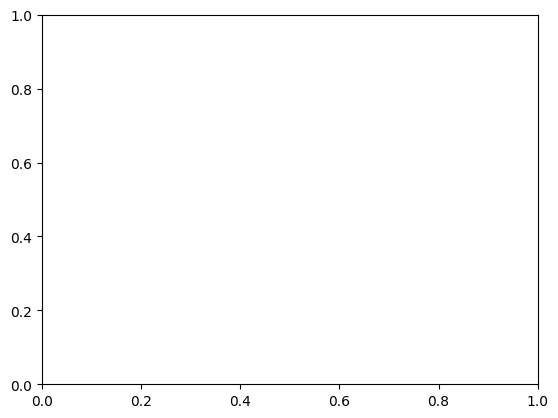

In [ ]:
import matplotlib.pyplot as plt 
import matplotlib.colors as colors


# Define the range of values that the colormap will map to colors
vmin = float(rain.min())
vmax = float(rain.max())

# Create a colorbar object with the desired range of values
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=a)

# Customize the colorbar
cb.set_label('X Values')
cb.ax.tick_params(labelsize=12)

# Show the plot
plt.show()

(-79.61677279999999, -36.30271189999985, -31.442498799999953, 5.2799548)

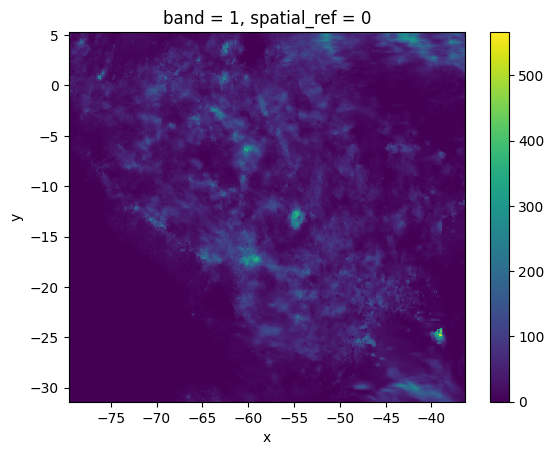

In [ ]:
array.sel(x=slice(xmin, xmax), y=slice(ymin, ymax)).plot()


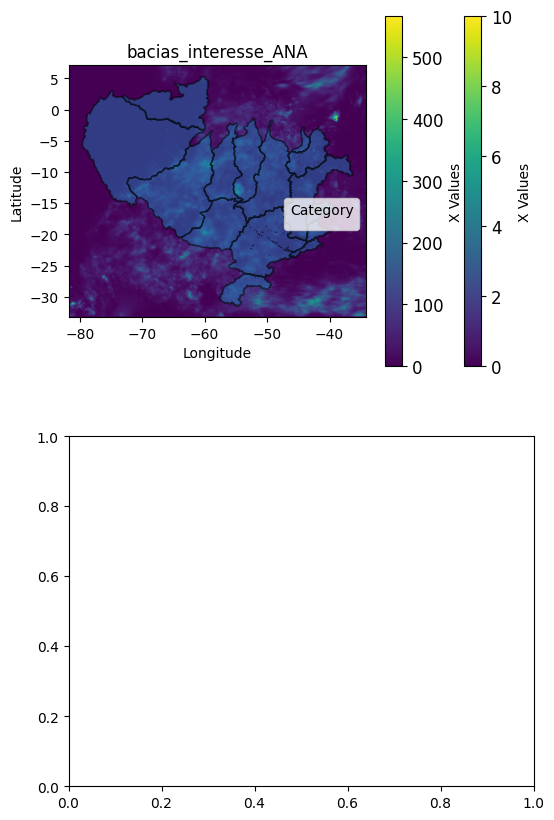

In [ ]:
a.figure

In [ ]:
import rasterio as rio
from raindownloader.utils import GISUtil

# create a memory file and use it to create a memory dataset
memfile = rio.MemoryFile()
profile = GISUtil.profile_from_xarray(rain)
with memfile.open(**profile) as memdset:

    # write the data to the newly created dataset
    memdset.write(rain)




In [ ]:
dset = rio.open(memfile)

In [ ]:
dset.bounds

BoundingBox(left=-120.10000000000001, bottom=32.3, right=-20.0, top=-60.099999999999994)

In [ ]:
dset.read().min()
dset.read().max()

566.1875

In [ ]:
import rioxarray as xrio

In [ ]:
memfile.seek(0)
array = xrio.open_rasterio(memfile)

In [ ]:
array.min()

<xarray.DataArray ()>
array(0., dtype=float32)
Coordinates:
    spatial_ref  int64 0

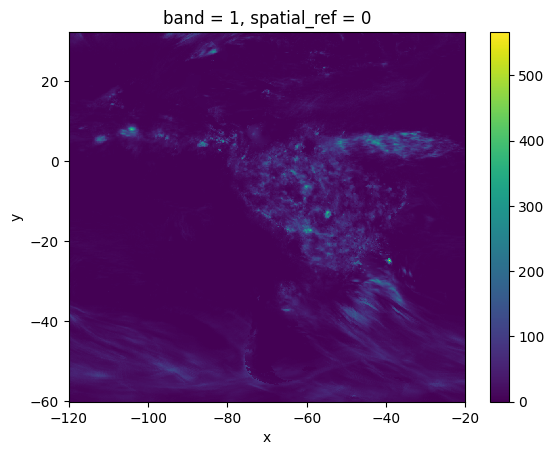

In [ ]:
array.plot()

In [ ]:
xmin, ymin, xmax, ymax = shp.total_bounds

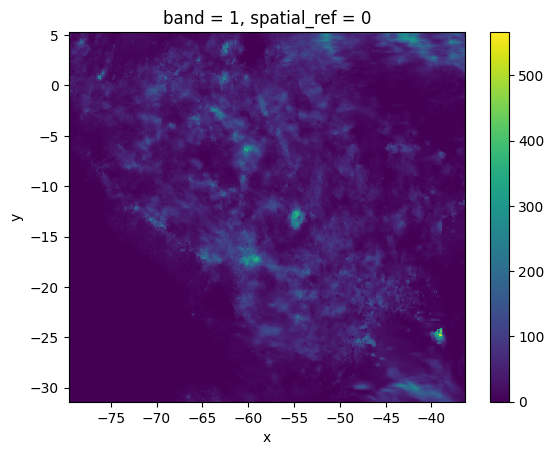

In [ ]:
array.sel(x=slice(xmin, xmax), y=slice(ymin, ymax)).plot()

## Mask The rain in the basin

In [ ]:
reporter.rain_in_geoms(array, doce['geometry'])

{'volume (kmˆ3)': 0.6132273416067483,
 'area (kmˆ2)': 82309.67327911961,
 'height (mm)': 7.450246334075928}

In [ ]:
82309.67327911961 * 7.450246334075928

613227.3416067483

In [ ]:
ana = gpd.read_file(basins['ANA']).to_crs(4326)


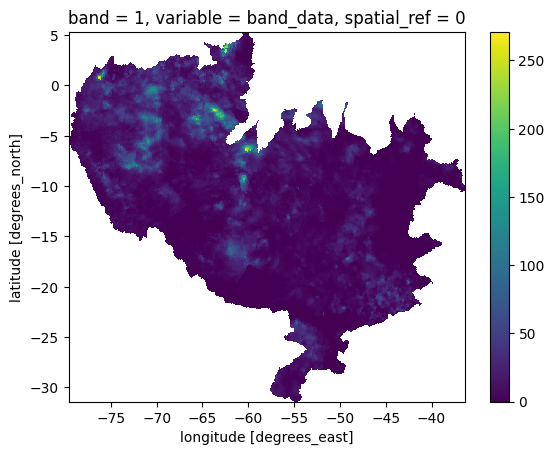

In [ ]:
array.rio.clip(ana['geometry']).plot()

In [ ]:
import rasterio as rio
import numpy as np
from shapely.geometry import mapping

In [ ]:
rain

<xarray.Dataset>
Dimensions:      (x: 1001, y: 924)
Coordinates:
    band         int64 1
  * x            (x) float64 -120.1 -120.0 -119.9 ... -20.25 -20.15 -20.05
  * y            (y) float64 -60.05 -59.95 -59.85 -59.75 ... 32.05 32.15 32.25
    spatial_ref  int64 0
Data variables:
    band_data    (y, x) float32 2.25 1.875 2.25 3.625 ... 2.5 1.875 1.375 1.5

In [ ]:
array_doce = array.rio.clip(doce['geometry'])

In [ ]:
array_doce.sum()

<xarray.DataArray ()>
array(5297.125, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

<Axes: >

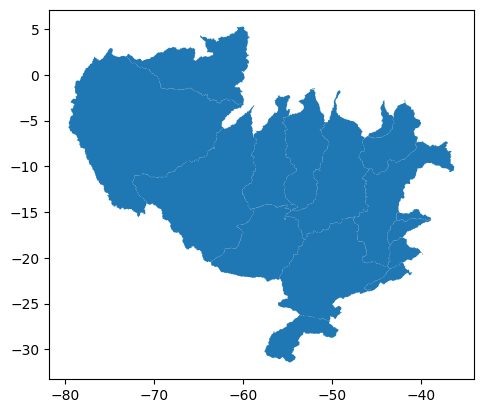

In [ ]:
ana.plot()

In [ ]:
ana['geometry'].area

/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/ipykernel_31270/3851139548.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ana['geometry'].area


0       4.324225
1       7.081579
2       5.918211
3      51.803004
4      78.549373
5       2.745356
6      26.822992
7      53.123010
8     180.558401
9      40.677920
10     18.860285
11     57.842105
12    114.216494
13      4.929860
14     63.498012
15     41.890955
dtype: float64

In [ ]:
import pandas as pd
pd.Series(map(lambda x: x, ana['geometry']))

0     POLYGON ((-44.2522434 -6.7052159, -44.2521122 ...
1     POLYGON ((-42.11707779999989 -17.7673023999998...
2     POLYGON ((-43.494483699999996 -18.6051583, -43...
3     POLYGON ((-56.84775499999989 -14.1465628999998...
4     POLYGON ((-51.39567929999998 -26.7257528999999...
5     POLYGON ((-41.661404 -16.014462599999998, -41....
6     POLYGON ((-44.9226871 -10.925408, -44.9236018 ...
7     POLYGON ((-39.896215999999924 -7.2628675999999...
8     POLYGON ((-71.1028402 -15.209528899999999, -71...
9     POLYGON ((-54.524526699999996 -14.884524299999...
10    POLYGON ((-54.777566999999976 -31.429217599999...
11    POLYGON ((-60.5145213 -3.2262078, -60.5156506 ...
12    POLYGON ((-62.7898735 -19.9057359, -62.7905054...
13    POLYGON ((-42.19563349999993 -20.4344145999999...
14    POLYGON ((-53.058853899999995 -18.0470755, -53...
15    POLYGON ((-53.9195274 -14.8370246, -53.9196209...
dtype: object

In [ ]:
doce = doce.to_crs(4326)
from pyproj import Geod

In [ ]:
geometry = doce['geometry'][0]

In [ ]:
# specify a named ellipsoid
geod = Geod(ellps="WGS84")

In [ ]:
abs(geod.geometry_area_perimeter(geometry)[0])/1e6

82309.67327911961

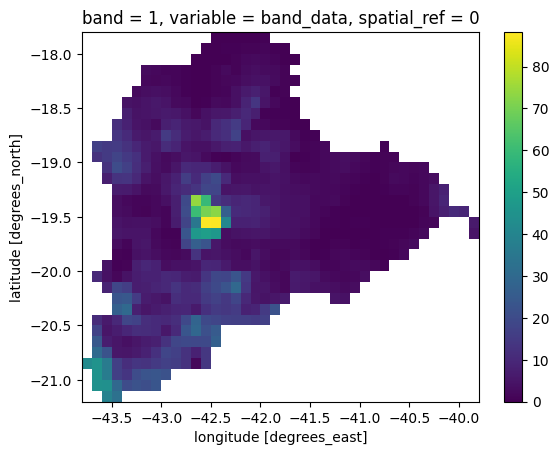

In [ ]:
array.rio.clip(doce['geometry']).plot()

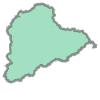

In [ ]:
geometry

In [ ]:
geometry.area

7.0815789798247755

In [ ]:
doce.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
rio.mask.mask(rain.rio, doce, nodata=255)

TypeError: bad operand type for unary ~: 'method'

In [ ]:
array.rio.transform

<bound method XRasterBase.transform of <rioxarray.raster_array.RasterArray object at 0x11f916220>>

In [ ]:
array.rio.nodata=np.nan

AttributeError: can't set attribute

In [ ]:
rio.mask.mask(nodata-)

Signature:
rio.mask.mask(
    dataset,
    shapes,
    all_touched=False,
    invert=False,
    nodata=None,
    filled=True,
    crop=False,
    pad=False,
    pad_width=0.5,
    indexes=None,
)
Docstring:
Creates a masked or filled array using input shapes.
Pixels are masked or set to nodata outside the input shapes, unless
`invert` is `True`.

If shapes do not overlap the raster and crop=True, a ValueError is
raised.  Otherwise, a warning is raised.

Parameters
----------
dataset : a dataset object opened in 'r' mode
    Raster to which the mask will be applied.
shapes : iterable object
    The values must be a GeoJSON-like dict or an object that implements
    the Python geo interface protocol (such as a Shapely Polygon).
all_touched : bool (opt)
    Include a pixel in the mask if it touches any of the shapes.
    If False (default), include a pixel only if its center is within one of
    the shapes, or if it is selected by Bresenham's line algorithm.
invert : bool (opt)
    If Fal

In [ ]:
doce = gpd.read_file(shapes/'bacia_Doce.shp')

In [ ]:
import xarray as xr

In [ ]:
dset = xr.open_dataset('../tmp/MERGE_CPTEC_20230101.grib2')

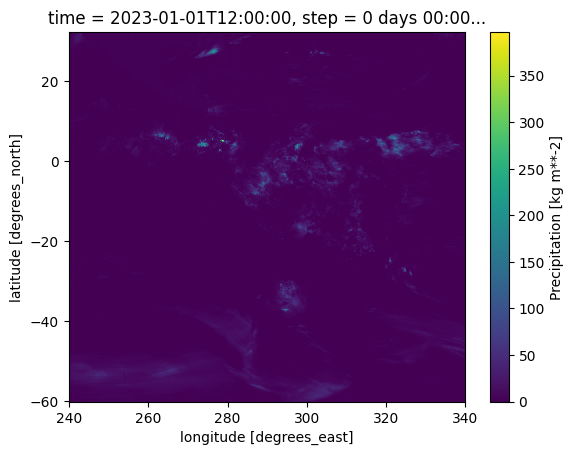

In [ ]:
dset['prec'].plot()

In [ ]:
doce.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
doce.to_crs(rain.rio.crs, inplace=True)

In [ ]:
doce.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

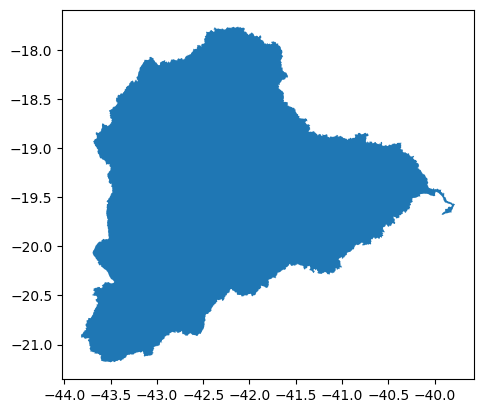

In [ ]:
ax = doce.plot()

In [ ]:
import tempfile
tempdir = tempfile.TemporaryDirectory()
temp = tempfile.NamedTemporaryFile(suffix='.tif')

In [ ]:
rain.rio.to_raster(temp.name)

In [ ]:
temp.name

'/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/tmpvlp51fxg.tif'

In [ ]:
temp.close()

In [ ]:
list(Path(tempdir.name).iterdir())

[]

In [ ]:
list(Path('/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/').iterdir())

[PosixPath('/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/com.apple.CloudPhotosConfiguration'),
 PosixPath('/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/com.apple.ImageIOXPCService'),
 PosixPath('/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/TelemetryUploadFilecom.microsoft.autoupdate.fba.txt'),
 PosixPath('/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/com.apple.PressAndHold'),
 PosixPath('/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/com.apple.avconferenced'),
 PosixPath('/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/python-languageserver-cancellation'),
 PosixPath('/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/vscode-git-fb1b491012.sock'),
 PosixPath('/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/com.apple.appleaccountd'),
 PosixPath('/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/com.apple.replayd'),
 PosixPath('/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/com.apple.ax.KonaTTSSupport.KonaSynthesizer'),
 PosixPath('/var/folders/j1/nkzpwxy956x_9m3tqxr331

In [ ]:
import rasterio as rio

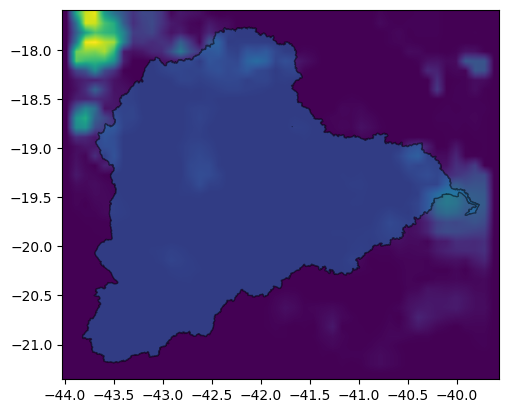

In [ ]:
ax = doce.plot(alpha=0.5, edgecolor='black')
cx.add_basemap(ax, source='../tmp/MERGE_CPTEC_20230101.tif')

In [ ]:
dataset.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1001, 'height': 924, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.1, 0.0, -120.10000000000001,
       0.0, 0.09999999999999999, -60.099999999999994), 'blockysize': 2, 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}

In [ ]:
dataset.read()

array([[[2.25 , 1.75 , 1.75 , ..., 0.   , 0.   , 0.   ],
        [0.75 , 0.625, 0.75 , ..., 0.   , 0.   , 0.   ],
        [0.5  , 0.375, 0.25 , ..., 0.   , 0.   , 0.   ],
        ...,
        [3.25 , 3.375, 3.625, ..., 2.375, 1.75 , 1.375],
        [2.25 , 2.125, 3.125, ..., 1.75 , 1.5  , 1.25 ],
        [2.875, 2.25 , 1.75 , ..., 1.75 , 1.375, 1.375]]], dtype=float32)

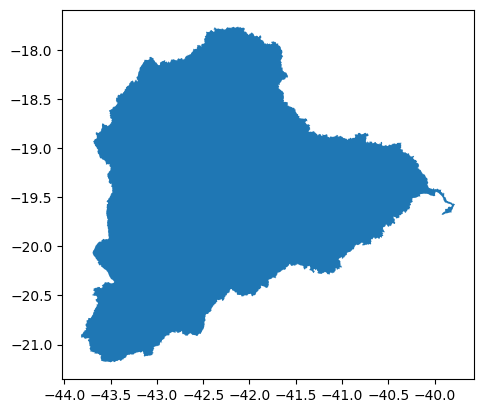

In [ ]:
ax = doce.plot()

In [ ]:
%%timeit
# open a geotiff file from disk
dataset = rio.open('../tmp/MERGE_CPTEC_20230101.tif')

# create a memory file and use it to create a memory dataset
with rio.MemoryFile() as memfile:
    with memfile.open(**dataset.profile) as memdset:

        # write the data to the newly created dataset
        memdset.write(dataset.read())
    
    # with the dataset in memory, add the basemap
    cx.add_basemap(ax, source=memfile)

139 ms ± 2.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


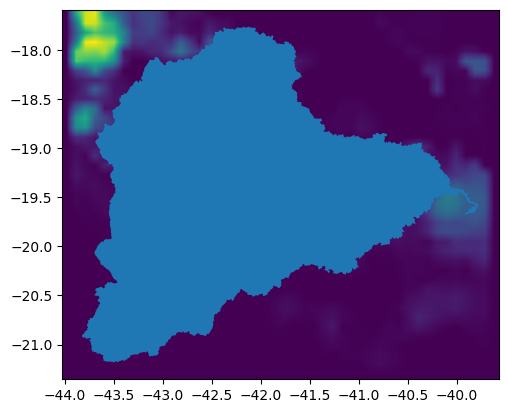

In [ ]:
ax.figure

### Option 2 - Writing it to disk

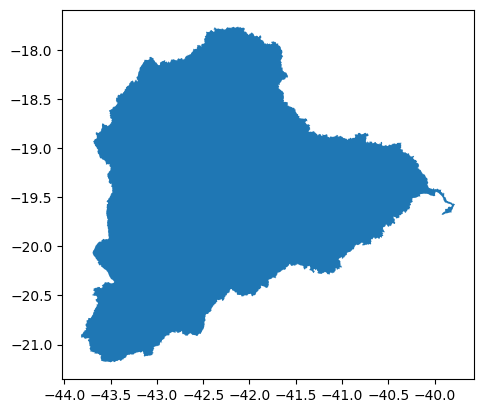

In [ ]:
ax = doce.plot()

In [ ]:
# %%timeit
# open a geotiff file from disk
dataset = rio.open('../tmp/MERGE_CPTEC_20230101.tif')

# get a tempfile
tmpfile = tempfile.NamedTemporaryFile(suffix='.tif')

# create a new geotiff file
with rio.open(tmpfile.name, 'w', **dataset.profile) as dst:
    # write the data from the input dataset to the output dataset
    dst.write(dataset.read())

dataset.close()

cx.add_basemap(ax, source=tmpfile.name)



142 ms ± 3.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# note that the file does not exist in disk
print(Path(tmpfile.name).exists())
tmpfile.close()

False


### Saving it to disk

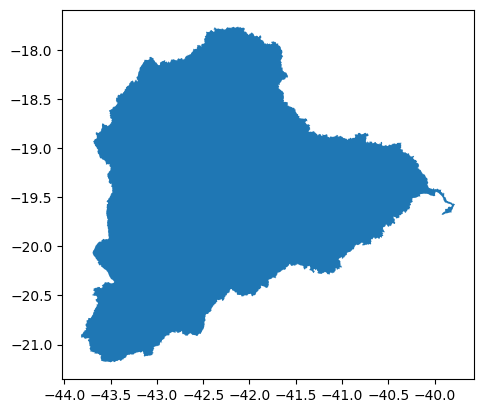

In [ ]:
ax = doce.plot()

In [ ]:
%%timeit
# open a geotiff file from disk
dataset = rio.open('../tmp/MERGE_CPTEC_20230101.tif')

# get a tempfile
tmpfile = '../tmp/test.tif'

# create a new geotiff file
with rio.open(tmpfile, 'w', **dataset.profile) as dst:
    # write the data from the input dataset to the output dataset
    dst.write(dataset.read())

dataset.close()

cx.add_basemap(ax, source=tmpfile)

142 ms ± 5.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


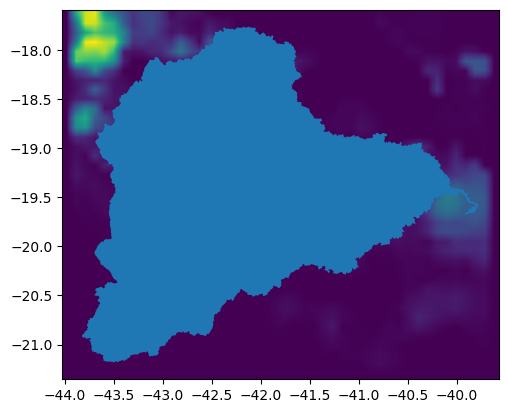

In [ ]:
ax.figure

### Working with Xarray

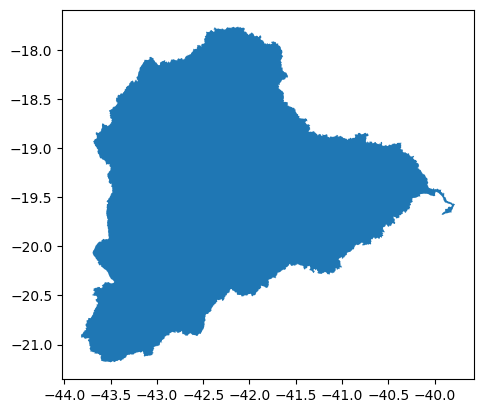

In [ ]:
ax = doce.plot()

In [ ]:
array = rain.to_array()


In [ ]:
array.data

array([[[ 2.25  ,  3.375 ,  3.5   , ...,  9.5   ,  8.25  ,  8.875 ],
        [ 4.25  ,  4.5   ,  5.125 , ...,  8.875 ,  7.375 ,  7.625 ],
        [ 5.5   ,  6.125 ,  5.875 , ...,  7.    ,  6.625 ,  7.125 ],
        ...,
        [17.125 , 17.5625, 19.375 , ...,  2.5   ,  2.    ,  1.625 ],
        [15.8125, 17.375 , 19.1875, ...,  1.875 ,  1.75  ,  1.5   ],
        [18.5   , 17.1875, 17.5625, ...,  2.    ,  1.5   ,  1.625 ]]],
      dtype=float32)

In [ ]:
from raindownloader.utils import GISUtil

In [ ]:
profile = GISUtil.profile_from_xarray(array)
profile

{'driver': 'GTiff',
 'width': 1001,
 'height': 924,
 'count': 1,
 'dtype': dtype('float32'),
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.1, 0.0, -120.10000000000001,
        0.0, 0.09999999999999999, -60.099999999999994),
 'nodata': None}

In [ ]:
# create a memory file and use it to create a memory dataset
profile = dict(
    driver='GTiff', 
    width=array.rio.width, 
    height=array.rio.height, 
    count=array.rio.count, 
    dtype=array.dtype, 
    crs=array.rio.crs, 
    transform=array.rio.transform(),
    nodata=array.rio.nodata
)

with rio.MemoryFile() as memfile:
    with memfile.open(**profile) as memdset:

        # write the data to the newly created dataset
        memdset.write(array)
    
    # with the dataset in memory, add the basemap
    cx.add_basemap(ax, source=memfile)

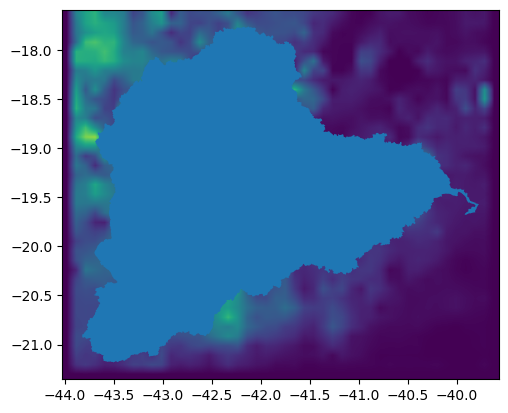

In [ ]:
ax.figure

In [ ]:
# tmpfile.close()


# # create a memory file and use it to create a memory dataset
# with rio.MemoryFile() as memfile:
#     with memfile.open(**dataset.profile) as memdset:

#         # write the data to the newly created dataset
#         memdset.write(dataset.read())
    
#     # with the dataset in memory, add the basemap
#     cx.add_basemap(ax, source=memfile)

In [ ]:
rain.rio.read

AttributeError: 'RasterDataset' object has no attribute 'read'

In [ ]:
tmpfile.name

'/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/tmpismf119n.tif'

In [ ]:
!ls -l /var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/*.tif

-rw-------@ 1 cordmaur  staff  0 Mar 16 10:53 /var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/tmpgb82a_s3.tif
-rw-------@ 1 cordmaur  staff  0 Mar 16 11:00 /var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/tmpi4h8935l.tif


In [ ]:
assert Path(tmpfile.name).exists()

AssertionError: 

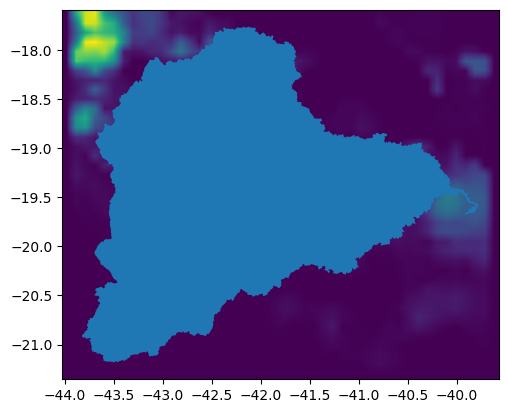

In [ ]:
ax.figure

In [ ]:
import rasterio as rio

# open a geotiff file from disk
dataset = rio.open('../tmp/MERGE_CPTEC_20230101.tif')

# create a memory file
memfile = rio.MemoryFile()

# create a memory dataset
memdset = memfile.open(**dataset.profile)
memdset.write(dataset.read())

# memdset.read()
memdset.read()

# # reset the memory file's cursor to the beginning
memfile.seek(0)

memdata = memfile.read()

print(memdata)

b'II*\x00\x08\x00\x00\x00\x10\x00\x00\x01\x03\x00\x01\x00\x00\x00\xe9\x03\x00\x00\x01\x01\x03\x00\x01\x00\x00\x00\x9c\x03\x00\x00\x02\x01\x03\x00\x01\x00\x00\x00 \x00\x00\x00\x03\x01\x03\x00\x01\x00\x00\x00\x08\x00\x00\x00\x06\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x11\x01\x04\x00\xce\x01\x00\x00\x06\x08\x00\x00\x15\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x16\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00\x17\x01\x04\x00\xce\x01\x00\x00\xce\x00\x00\x00\x1c\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00=\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00S\x01\x03\x00\x01\x00\x00\x00\x03\x00\x00\x00\xd8\x85\x0c\x00\x10\x00\x00\x00>\x0f\x00\x00\xaf\x87\x03\x00 \x00\x00\x00\xbe\x0f\x00\x00\xb0\x87\x0c\x00\x02\x00\x00\x00\xfe\x0f\x00\x00\xb1\x87\x02\x00\x08\x00\x00\x00\x0e\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [ ]:
memfile.seek?

Docstring: <no docstring>
Type:      builtin_function_or_method

In [ ]:
memfile.seek(0)
memfile.read()

b'II*\x00\x08\x00\x00\x00\x10\x00\x00\x01\x03\x00\x01\x00\x00\x00\xe9\x03\x00\x00\x01\x01\x03\x00\x01\x00\x00\x00\x9c\x03\x00\x00\x02\x01\x03\x00\x01\x00\x00\x00 \x00\x00\x00\x03\x01\x03\x00\x01\x00\x00\x00\x08\x00\x00\x00\x06\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x11\x01\x04\x00\xce\x01\x00\x00\x06\x08\x00\x00\x15\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x16\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00\x17\x01\x04\x00\xce\x01\x00\x00\xce\x00\x00\x00\x1c\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00=\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00S\x01\x03\x00\x01\x00\x00\x00\x03\x00\x00\x00\xd8\x85\x0c\x00\x10\x00\x00\x00>\x0f\x00\x00\xaf\x87\x03\x00 \x00\x00\x00\xbe\x0f\x00\x00\xb0\x87\x0c\x00\x02\x00\x00\x00\xfe\x0f\x00\x00\xb1\x87\x02\x00\x08\x00\x00\x00\x0e\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [ ]:
memfile.read()

b''

In [ ]:
dset2 = rio.open(fp=memfile)

RasterioIOError: '/vsipythonfilelike/6401a6ef-7c49-47b3-b341-75061e96b73a/6401a6ef-7c49-47b3-b341-75061e96b73a' not recognized as a supported file format.

In [ ]:
cx.add_basemap(source=memfile, ax=ax)

RasterioIOError: '/vsipythonfilelike/fee30ddc-aa04-4dc9-89e7-61590c71d577/fee30ddc-aa04-4dc9-89e7-61590c71d577' not recognized as a supported file format.

In [ ]:
type(memfile)

rasterio.io.MemoryFile

In [ ]:
2

2

In [ ]:
memfile.close()

In [ ]:
rio.open(memfile)

RasterioIOError: '/vsipythonfilelike/3f4881df-57f5-4fcc-a1e1-e8d45391ecd4/3f4881df-57f5-4fcc-a1e1-e8d45391ecd4' not recognized as a supported file format.

In [ ]:
type(memfile), type(memdset), type(dataset)

(rasterio.io.MemoryFile, rasterio.io.DatasetWriter, rasterio.io.DatasetReader)

In [ ]:
cx.add_basemap(source=)

924

In [ ]:
rain.rio.height

924

In [ ]:
rio.open(memfile)

RasterioIOError: '/vsipythonfilelike/43afb194-8ee4-4ba9-a742-517ae4b1ebe2/43afb194-8ee4-4ba9-a742-517ae4b1ebe2' not recognized as a supported file format.

In [ ]:
rio.open(memfile)

RasterioIOError: '/vsipythonfilelike/41846160-ea9c-4080-9c80-29c4ebcb98d4/41846160-ea9c-4080-9c80-29c4ebcb98d4' not recognized as a supported file format.

In [ ]:
cx.add_basemap(ax, source=memdset)

IndexError: band index 1024 out of range (not in (1,))

Exception ignored in: 'rasterio._filepath.filepath_read'
Traceback (most recent call last):
  File "rasterio/_io.pyx", line 496, in rasterio._io.DatasetReaderBase.read
IndexError: band index 1024 out of range (not in (1,))


AttributeError: 'DatasetWriter' object has no attribute 'seek'

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "rasterio/_filepath.pyx", line 141, in rasterio._filepath.filepath_seek
AttributeError: 'DatasetWriter' object has no attribute 'seek'


SystemError: <built-in method replace of str object at 0x17d3f9b70> returned a result with an error set

In [ ]:
with rio.MemoryFile() as mem:
    with mem.open(**dataset.profile) as dst:
        dst.write(dataset.read())

In [ ]:
cx.add_basemap(ax, source=mem)

: 

: 

In [ ]:
with MemoryFile() as memfile:
    memfile.write

In [ ]:
MemoryFile?

Init signature: MemoryFile(file_or_bytes=None, dirname=None, filename=None, ext='.tif')
Docstring:     
A BytesIO-like object, backed by an in-memory file.

This allows formatted files to be read and written without I/O.

A MemoryFile created with initial bytes becomes immutable. A
MemoryFile created without initial bytes may be written to using
either file-like or dataset interfaces.

Examples
--------

A GeoTIFF can be loaded in memory and accessed using the GeoTIFF
format driver

>>> with open('tests/data/RGB.byte.tif', 'rb') as f, MemoryFile(f) as memfile:
...     with memfile.open() as src:
...         pprint.pprint(src.profile)
...
{'count': 3,
 'crs': CRS({'init': 'epsg:32618'}),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 718,
 'interleave': 'pixel',
 'nodata': 0.0,
 'tiled': False,
 'transform': Affine(300.0379266750948, 0.0, 101985.0,
       0.0, -300.041782729805, 2826915.0),
 'width': 791}
Init docstring:
Create a new file in memory

Parameters
----------
file_or_byte

In [ ]:
from rasterio import MemoryFile

In [ ]:
cx.add_basemap(ax, source=dataset)

IndexError: band index 1024 out of range (not in (1,))

Exception ignored in: 'rasterio._filepath.filepath_read'
Traceback (most recent call last):
  File "rasterio/_io.pyx", line 496, in rasterio._io.DatasetReaderBase.read
IndexError: band index 1024 out of range (not in (1,))


AttributeError: 'DatasetReader' object has no attribute 'seek'

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "rasterio/_filepath.pyx", line 141, in rasterio._filepath.filepath_seek
AttributeError: 'DatasetReader' object has no attribute 'seek'


SystemError: <built-in method replace of str object at 0x12f9c6630> returned a result with an error set

In [ ]:
rio.DatasetReader?

Docstring:      An unbuffered data and metadata reader
Init docstring:
Construct a new dataset

Parameters
----------
path : rasterio.path.Path or str
    Path of the local or remote dataset.
driver : str or list of str
    A single driver name or a list of driver names to consider when
    opening the dataset.
sharing : bool, optional
    Whether to share underlying GDAL dataset handles (default: False).
kwargs : dict
    GDAL dataset opening options.

Returns
-------
dataset
File:           ~/miniconda3/envs/geopandas38/lib/python3.8/site-packages/rasterio/io.py
Type:           type
Subclasses:     

In [ ]:
tempfile.name

'/var/folders/j1/nkzpwxy956x_9m3tqxr331940000gn/T/tmpi4h8935l.tif'

In [ ]:
tempfile.NamedTemporaryFile()

In [ ]:
p = Path(tempdir)

In [ ]:
p.exists()

True

In [ ]:
temp.

In [ ]:
rain.rio.to_raster(temp)

TypeError: expected str, bytes or os.PathLike object, not _TemporaryFileWrapper

In [ ]:
rain.to_array().values

array([[[ 2.25  ,  3.375 ,  3.5   , ...,  9.5   ,  8.25  ,  8.875 ],
        [ 4.25  ,  4.5   ,  5.125 , ...,  8.875 ,  7.375 ,  7.625 ],
        [ 5.5   ,  6.125 ,  5.875 , ...,  7.    ,  6.625 ,  7.125 ],
        ...,
        [17.125 , 17.5625, 19.375 , ...,  2.5   ,  2.    ,  1.625 ],
        [15.8125, 17.375 , 19.1875, ...,  1.875 ,  1.75  ,  1.5   ],
        [18.5   , 17.1875, 17.5625, ...,  2.    ,  1.5   ,  1.625 ]]],
      dtype=float32)

In [ ]:
import io

In [ ]:
stream = io.BytesIO()

In [ ]:
rain.rio.to_raster(stream)

TypeError: expected str, bytes or os.PathLike object, not _io.BytesIO

In [ ]:
import rioxarray as xrio

In [ ]:
type(data.rio)

rioxarray.raster_array.RasterArray

In [ ]:
files

[PosixPath('../tmp/MERGE_CPTEC_20230101.tif'),
 PosixPath('../tmp/MERGE_CPTEC_20230102.tif'),
 PosixPath('../tmp/MERGE_CPTEC_20230103.tif'),
 PosixPath('../tmp/MERGE_CPTEC_20230104.tif'),
 PosixPath('../tmp/MERGE_CPTEC_20230105.tif')]

In [ ]:
data = xrio.open_rasterio(files[0])

In [ ]:
data.to

Object `data.rio.BytesIO` not found.


In [ ]:
rain.rio

In [ ]:
file = downloader.download_file('2023-03-05', local_folder='../tmp', file_type=FileType.GEOTIFF)
assert file.exists()

file ../tmp/MERGE_CPTEC_20230305.grib2 already exists.


In [ ]:
files = downloader.download_range(
    start_date='20230101', 
    end_date='20230105', 
    local_folder='../tmp',
    file_type=FileType.GEOTIFF
)

file ../tmp/MERGE_CPTEC_20230101.grib2 already exists.
file ../tmp/MERGE_CPTEC_20230102.grib2 already exists.
file ../tmp/MERGE_CPTEC_20230103.grib2 already exists.
file ../tmp/MERGE_CPTEC_20230104.grib2 already exists.
file ../tmp/MERGE_CPTEC_20230105.grib2 already exists.


In [ ]:
cube = Downloader.create_cube(files, squeeze_dims='band')
cube

<xarray.Dataset>
Dimensions:      (x: 1001, y: 924, time: 5)
Coordinates:
    band         int64 1
  * x            (x) float64 -120.1 -120.0 -119.9 ... -20.25 -20.15 -20.05
  * y            (y) float64 -60.05 -59.95 -59.85 -59.75 ... 32.05 32.15 32.25
    spatial_ref  int64 0
  * time         (time) int64 0 1 2 3 4
Data variables:
    band_data    (time, y, x) float32 2.25 1.75 1.75 3.0 ... 0.0 0.0 0.0 0.0

In [ ]:
cube

<xarray.Dataset>
Dimensions:      (x: 1001, y: 924, time: 5)
Coordinates:
    band         int64 1
  * x            (x) float64 -120.1 -120.0 -119.9 ... -20.25 -20.15 -20.05
  * y            (y) float64 -60.05 -59.95 -59.85 -59.75 ... 32.05 32.15 32.25
    spatial_ref  int64 0
  * time         (time) int64 0 1 2 3 4
Data variables:
    band_data    (time, y, x) float32 2.25 1.75 1.75 3.0 ... 0.0 0.0 0.0 0.0

In [ ]:
cube.su

In [ ]:
INPE.parse_MERGE_filename(files[0])

{'date': datetime.datetime(2023, 1, 1, 0, 0)}

In [ ]:
time_cube = Downloader.create_cube(files, name_parser=INPE.parse_MERGE_filename, dim_key='date', squeeze_dims='band')

In [ ]:
time_cube

<xarray.Dataset>
Dimensions:      (x: 1001, y: 924, date: 5)
Coordinates:
    band         int64 1
  * x            (x) float64 -120.1 -120.0 -119.9 ... -20.25 -20.15 -20.05
  * y            (y) float64 -60.05 -59.95 -59.85 -59.75 ... 32.05 32.15 32.25
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-01-05
Data variables:
    band_data    (date, y, x) float32 2.25 1.75 1.75 3.0 ... 0.0 0.0 0.0 0.0

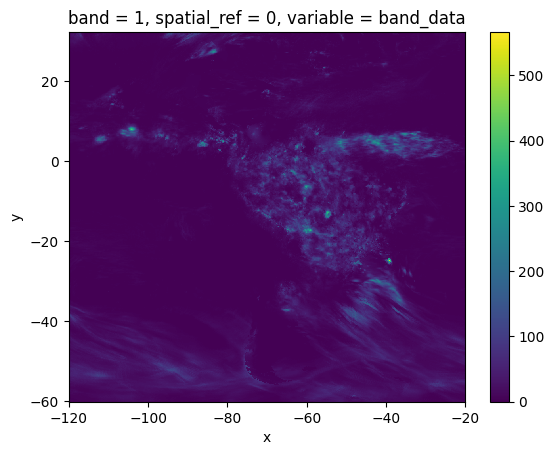

In [ ]:
time_cube.sum(dim='date').to_array().plot()

In [ ]:
import xarray as xr

In [ ]:
data_arrays = [xr.open_dataset(file) for file in files]

# for i, array in enumerate(data_arrays):
#     array.assign_coords({'time': i})

In [ ]:
cube

<xarray.Dataset>
Dimensions:      (band: 1, x: 1001, y: 924, time: 5)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -120.1 -120.0 -119.9 ... -20.25 -20.15 -20.05
  * y            (y) float64 -60.05 -59.95 -59.85 -59.75 ... 32.05 32.15 32.25
    spatial_ref  int64 0
Dimensions without coordinates: time
Data variables:
    band_data    (time, band, y, x) float32 2.25 1.75 1.75 3.0 ... 0.0 0.0 0.0

In [ ]:
coords = [f'File {i}' for i in range(len(files))]
coords

['File 0', 'File 1', 'File 2', 'File 3', 'File 4']

In [ ]:
cube = xr.concat(data_arrays, dim='time')

In [ ]:
cube.assign_coords(coords={'time': coords})

<xarray.Dataset>
Dimensions:      (band: 1, x: 1001, y: 924, time: 5)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -120.1 -120.0 -119.9 ... -20.25 -20.15 -20.05
  * y            (y) float64 -60.05 -59.95 -59.85 -59.75 ... 32.05 32.15 32.25
    spatial_ref  int64 0
  * time         (time) <U6 'File 0' 'File 1' 'File 2' 'File 3' 'File 4'
Data variables:
    band_data    (time, band, y, x) float32 2.25 1.75 1.75 3.0 ... 0.0 0.0 0.0

In [ ]:
xr.concat?

Signature:
xr.concat(
    objs,
    dim,
    data_vars='all',
    coords='different',
    compat: 'CompatOptions' = 'equals',
    positions=None,
    fill_value=<NA>,
    join: 'JoinOptions' = 'outer',
    combine_attrs: 'CombineAttrsOptions' = 'override',
)
Docstring:
Concatenate xarray objects along a new or existing dimension.

Parameters
----------
objs : sequence of Dataset and DataArray
    xarray objects to concatenate together. Each object is expected to
    consist of variables and coordinates with matching shapes except for
    along the concatenated dimension.
dim : Hashable or DataArray or pandas.Index
    Name of the dimension to concatenate along. This can either be a new
    dimension name, in which case it is added along axis=0, or an existing
    dimension name, in which case the location of the dimension is
    unchanged. If dimension is provided as a DataArray or Index, its name
    is used as the dimension to concatenate along and the values are added
    as a coord

In [ ]:
cube.time

<xarray.DataArray 'time' (time: 5)>
array([0, 1, 2, 3, 4])
Coordinates:
    spatial_ref  int64 0
Dimensions without coordinates: time

In [ ]:
array = data_arrays[0]

In [ ]:
from datetime import datetime

In [ ]:
datetime.now()

datetime.datetime(2023, 3, 14, 16, 24, 2, 738128)

In [ ]:
array

<xarray.Dataset>
Dimensions:      (band: 1, x: 1001, y: 924)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -120.1 -120.0 -119.9 ... -20.25 -20.15 -20.05
  * y            (y) float64 -60.05 -59.95 -59.85 -59.75 ... 32.05 32.15 32.25
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [ ]:
array = array.assign_coords({'time': datetime.now()})

In [ ]:
array.time

<xarray.DataArray 'time' ()>
array('2023-03-14T16:24:04.965328000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 ...
    time         datetime64[ns] 2023-03-14T16:24:04.965328

In [ ]:
array = array.expand_dims(time=1)

In [ ]:
array.squeeze('band')


<xarray.Dataset>
Dimensions:      (x: 1001, y: 924, time: 1)
Coordinates:
    band         int64 1
  * x            (x) float64 -120.1 -120.0 -119.9 ... -20.25 -20.15 -20.05
  * y            (y) float64 -60.05 -59.95 -59.85 -59.75 ... 32.05 32.15 32.25
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 2023-03-14T16:24:04.965328
Data variables:
    band_data    (time, y, x) float32 2.25 1.75 1.75 3.0 ... 1.75 1.375 1.375